In [1]:
import numpy as np
import matplotlib.pyplot as plt
import flpoAgent
import importlib
import random
from scipy.spatial.distance import cdist
import createEnv
from scipy.optimize import Bounds
from scipy.optimize import LinearConstraint
import supporting_functions
from matplotlib.cm import get_cmap

n_waypoints: 6 
n_agents: 3 
CAT:
[3. 3. 3. 3. 3. 3.] 
b1:
[0.7 0.7 0.7 0.7 0.7 0.7] 
b2:
[0. 0. 0. 0. 0. 0.]
---------
wp_locations:
[[-6.39460622e+00 -9.61049517e+00]
 [ 4.99264371e+02  4.49867858e+00]
 [ 9.98404072e+02 -2.91458037e-01]
 [-9.74438371e+00  4.99747432e+02]
 [ 5.08836133e+02  5.07015902e+02]
 [ 1.00459929e+03  4.92174721e+02]] 
mask:
[[0 1 0 1 0 0]
 [1 0 1 0 1 0]
 [0 1 0 0 0 1]
 [1 0 0 0 1 0]
 [0 1 0 1 0 1]
 [0 0 1 0 1 0]] 
dist_mat:
[[1.00000000e+08 5.05855779e+02 1.00000000e+08 5.09368942e+02
  1.00000000e+08 1.00000000e+08]
 [5.05855779e+02 1.00000000e+08 4.99162686e+02 1.00000000e+08
  5.02608375e+02 1.00000000e+08]
 [1.00000000e+08 4.99162686e+02 1.00000000e+08 1.00000000e+08
  1.00000000e+08 4.92505146e+02]
 [5.09368942e+02 1.00000000e+08 1.00000000e+08 1.00000000e+08
  5.18631452e+02 1.00000000e+08]
 [1.00000000e+08 5.02608375e+02 1.00000000e+08 5.18631452e+02
  1.00000000e+08 4.95985250e+02]
 [1.00000000e+08 1.00000000e+08 4.92505146e+02 1.00000000e+08
  4.95985

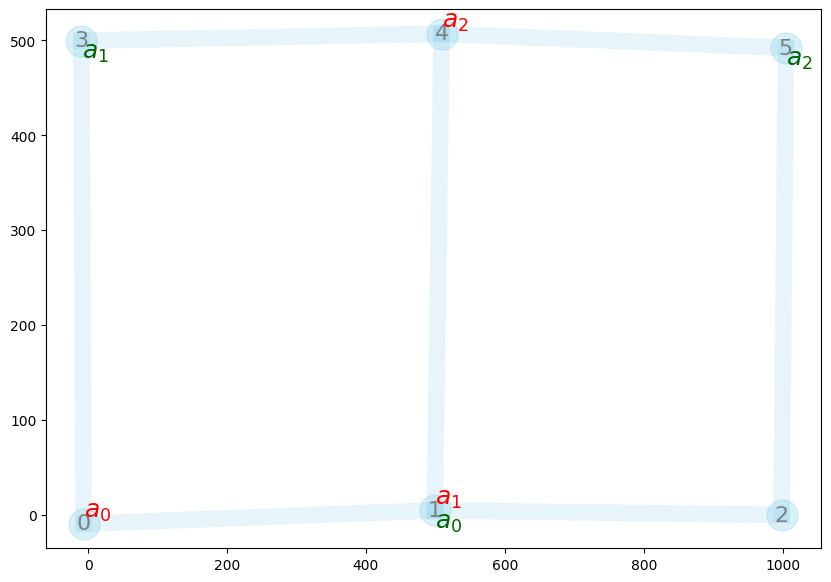

In [2]:
importlib.reload(flpoAgent)
importlib.reload(createEnv)
importlib.reload(supporting_functions)

# generate waypoints and the adjacency matrix
n_waypoints = 6
n_agents = 3
tolArray = np.random.uniform(3.0, 3.0, n_waypoints)
b1 = np.ones(n_waypoints)*0.7
b2 = np.ones(n_waypoints)*0.0

# Grid network parameters
grid_params = {
    'type':'grid',
    'n_points':n_waypoints,
    'grid_size':1000,
    'noise_factor':10
}

# Ring network parameters
ring_params = {
    'type':'ring',
    'num_rings':3,
    'points_per_ring':int(n_waypoints/3),
    'center_distance':200,
    'deformation_level':50.0,
    'extra_connections':0.00,
    'missing_connections':0.05
}

# create a mars environment
mars = createEnv.MARS(
    n_waypoints, 
    n_agents, 
    tolArray, 
    b1, 
    b2, 
    grid_params, 
    seed=11, 
    printFlag=True)
    
# compute conflict cost
beta0=1e-8
gamma_t = 5e0
gamma_c = 1e-2
coeff_t = 50
coeff_c = 0.01
# calculate conflict cost
# print(f'mars_schedule:\n{np.round(mars.sched_mat,2)}')
# Xi = mars.agents[1].returnStageWiseCost(mars.sched_mat[1,:], mars.dist_mat, gamma_t, coeff_t)
# Pb = mars.agents[1].getPathAssociations(mars.sched_mat[1,:], mars.dist_mat, beta0, gamma_t, coeff_t)
# print(f'agent start:{mars.agents[1].s}\nprobability:\n{Pb[1]}\nstageWiseCost:{Xi[1]}')

reach_mat = mars.calc_agent_reach_mat(
        mars.sched_mat, 
        beta=beta0, gamma=gamma_t, coeff=coeff_t)
filter_wp = np.ones(shape=reach_mat.shape)
filter_wp[reach_mat <= 1.0e-10] = 0.0 
print(f'reach_mat')
print(f'filter_wp:\n{filter_wp}')
mars.transportCost(mars.sched_mat, beta=beta0, gamma=gamma_t, coeff=coeff_t)
print(f'transport_cost:\n{mars.C_agents}')
mars.conflictCost(mars.sched_mat, gamma=gamma_c, coeff=coeff_c, filter_wp=filter_wp)
print(f'conflict_cost:\n{mars.C_wp_conflict}')

# mars visualization
# agent_routes, agent_schedules, agent_colors = createEnv.calc_agent_routes_and_schedules(mars, Pb_a=[], printRoutes=False)
cmap = get_cmap('tab20')
agent_colors = {a: cmap(i / mars.n_agents) for i, a in enumerate(range(mars.n_agents))}
createEnv.plotNetwork(mars=mars, figuresize=(10,7), routes=[], agent_colors=agent_colors, showEdgeLength=False, plotPaths=False)

# agent visualization
show_graph=0
if show_graph:
    for i,v in enumerate(mars.agents):
        v.showGraph(mars.wp_locations, mars.dist_mat, mars.mask, mars.sched_mat[i,:], figuresize=(10,5), showEdgeTimeLim=True) 



In [3]:

# annealing
sched_vec0 = mars.sched_mat.flatten()

lb = np.ones(shape=sched_vec0.shape)*mars.t_start_min
ub = np.ones(shape=sched_vec0.shape)*1000.0
# for i,ag in enumerate(mars.agents):
#     lb[i*mars.n_waypoints+ag.s] = mars.t_start_min
#     ub[i*mars.n_waypoints+ag.s] = 100.0
print(f'agent start nodes {mars.agents[0].s}')
print(f'init schedule vec {sched_vec0}')
print(f'ub {ub}')
print(f'lb {lb}')

sched_bounds = [lb,ub]
beta_lims = [1e-3,1e2]
beta_grow = 3
# opts = {'gtol':1e-4, 'verbose':0, 'maxiter':200}
opts = {'disp':0}
C_arr, sched_vec, rt_arr, reach_mat_beta_data, filter_wp_beta_data, beta_arr, gamma_arr, conflict_C_arr, Pb_a = mars.annealing(beta_lims=beta_lims,
                                            beta_grow=beta_grow,
                                            sched_vec0=sched_vec0,
                                            init_sched_bounds=sched_bounds,
                                            optimize_opt=opts,
                                            allowPrintAnneal=True,
                                            allowPrintOptimize=False)



agent start nodes 1
init schedule vec [72.99644702  0.         89.39041703 85.71542471 16.50866176 63.23340138
  2.04836128 11.67372688 31.63673116  0.         75.89795882 81.82753579
 34.4624491  31.87987969 11.1661232   8.39531433 71.27259357  0.        ]
ub [1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000.]
lb [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

beta:1.000e-03	gamma_t:5.000e+00	gamma_c:7.500e+00	coeff_t:5.000e+01	coeff_c:5.000e+00
filter_wp:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.],
	reach_mat:[0.785 1.    0.108 0.112 0.157 0.064 0.292 0.853 0.122 1.    0.708 0.04
 0.029 0.244 0.193 0.092 0.807 1.   ]
C_agents:[-1302.94   145.65 -1890.03],
C_conflict:[0.14 0.14 0.14 0.14 0.14 0.14],
	cost:-3046.50

beta:3.000e-03	gamma_t:6.000e+00	gamma_c:7.500e+00	coeff_t:5.000e+01	coeff_c:5.000e+00
filter_wp:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.],
	reach_mat:[0.986 1.    0.004 0.013 0.01


Optimization Results
initial schedule:[72.99644702  0.         89.39041703 85.71542471 16.50866176 63.23340138
  2.04836128 11.67372688 31.63673116  0.         75.89795882 81.82753579
 34.4624491  31.87987969 11.1661232   8.39531433 71.27259357  0.        ]
final schedule:
[[1.91425512e+01 7.66493604e-02 4.59701457e-03 3.40013215e-03
  4.10692173e-03 4.75561706e-03]
 [1.59715011e+01 3.23407479e+01 1.23764529e-03 5.56027119e-03
  1.20174000e-03 9.26813882e-03]
 [7.32895206e-03 9.45168325e-03 5.65886078e-03 9.48994455e-03
  1.59780675e+01 9.18405730e-03]]
processing time:
[[0.         3.95959456 3.80335296 4.695958   4.43569836 4.2041281 ]
 [4.10476764 0.         4.97334666 3.6761081  3.47974936 4.59287151]
 [3.12737286 3.72923129 3.14004561 3.63873541 0.         3.58052733]]
cost:67.73422897931204
route v0: [1, 0], schedule: [ 0.08 19.14]
route v1: [3, 0, 1], schedule: [1.000e-02 1.597e+01 3.234e+01]
route v2: [5, 4], schedule: [1.000e-02 1.598e+01]


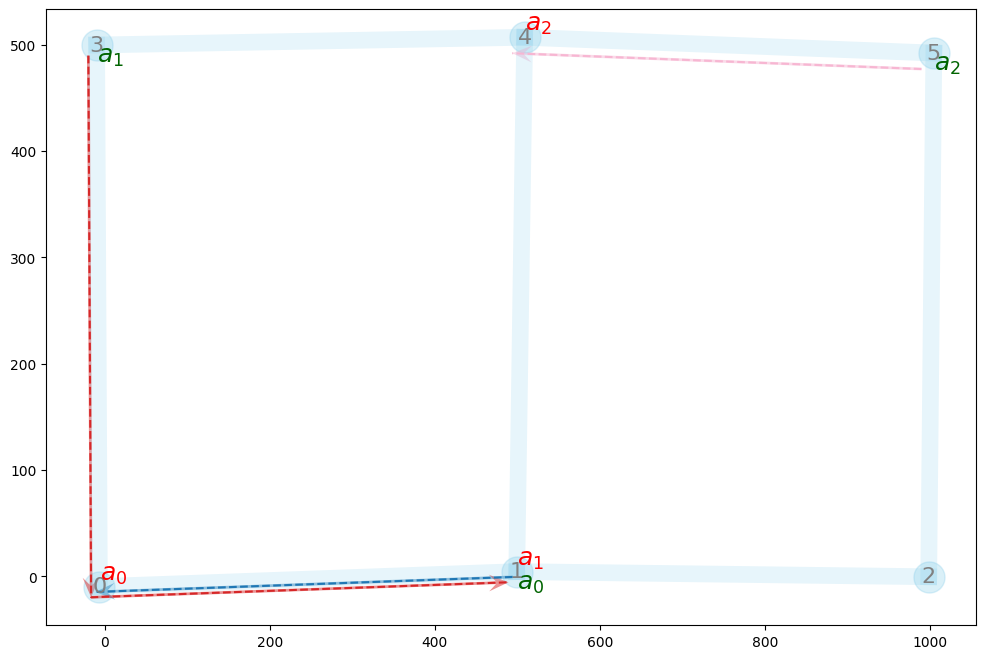

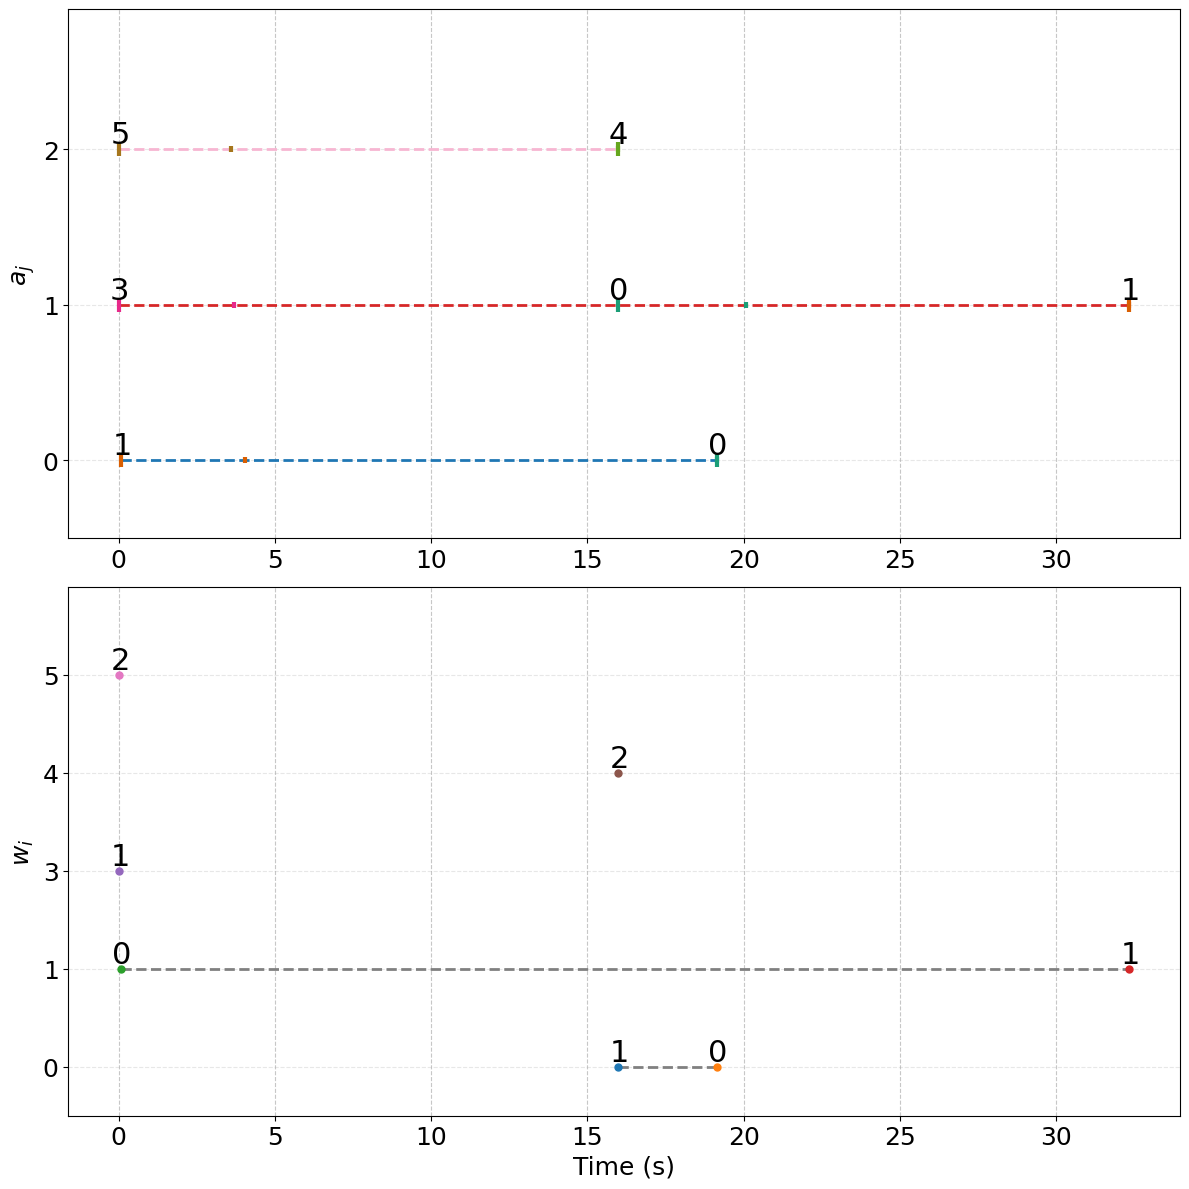

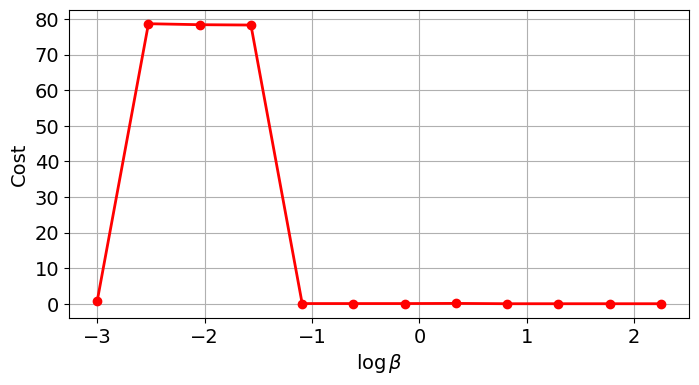

In [4]:
importlib.reload(createEnv)
importlib.reload(flpoAgent)
print('\nOptimization Results')
print(f'initial schedule:{sched_vec0}')
print(f'final schedule:\n{mars.sched_mat}')
print(f'processing time:\n{mars.process_T}')
print(f'cost:{C_arr[-1]}')

agent_routes, agent_schedules = createEnv.calc_agent_routes_and_schedules(mars, Pb_a, printRoutes=True)
createEnv.plotNetwork(mars=mars, figuresize=(12,8), routes=agent_routes, agent_colors=agent_colors, showEdgeLength=False, plotPaths=True)
# createEnv.plot_vehicle_routes(agent_routes, agent_schedules, mars.process_T, agent_colors)
# createEnv.plot_waypoint_schedules(filter_wp_beta_data[-1], mars.sched_mat)
createEnv.plot_waypoint_agent_schedules(
    agent_routes, agent_schedules, mars.sched_mat, 
    filter_wp_beta_data[-1], mars.process_T, agent_colors,
    figuresize=(12,12))
plt.figure(figsize=(8,4))
plt.plot(np.log(beta_arr)/np.log(10), conflict_C_arr.sum(axis=1), marker='o', linewidth=2, color='red')
plt.xlabel(rf'$\log\beta$', fontsize=14)
plt.ylabel(rf'Cost', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.title(rf'Cumulative conflict management')
# plt.legend([rf"$w_{str(i)}$" for i in range(conflict_C_arr.shape[1])])
plt.grid()
plt.show()
# agent visualization
show_graph=0
if show_graph:
    for i,v in enumerate(mars.agents):
        v.showGraph(mars.wp_locations, mars.dist_mat, mars.mask, mars.sched_mat[i,:], figuresize=(10,5), showEdgeTimeLim=True)

# # show path associations
# Pb = mars.agents[0].getPathAssociations(mars.sched_mat[0,:], mars.dist_mat, beta_arr[-1], gamma_arr[-1][0], gamma_arr[-1][2])
# Xi = mars.agents[0].returnStageWiseCost(mars.sched_mat[5,:], mars.dist_mat, gamma_arr[-1][0], gamma_arr[-1][2])
# mars.agents[0].getFreeEnergy_s(mars.sched_mat[0,:], mars.dist_mat, beta=beta_arr[-1], gamma=gamma_arr[-1][0], coeff=gamma_arr[-1][2])
# print(f'freeEnergy: {mars.agents[0].freeEnergy_s}')
# print(f'path association:\n{Pb}')
# print(f'path costs:\n{Xi}')
# # test weighedLassoCost
# cost = createEnv.weighedLassoCost(mars, mars.sched_mat, beta=beta_arr[-1], gamma=beta_arr[-1], tol=1e-3)


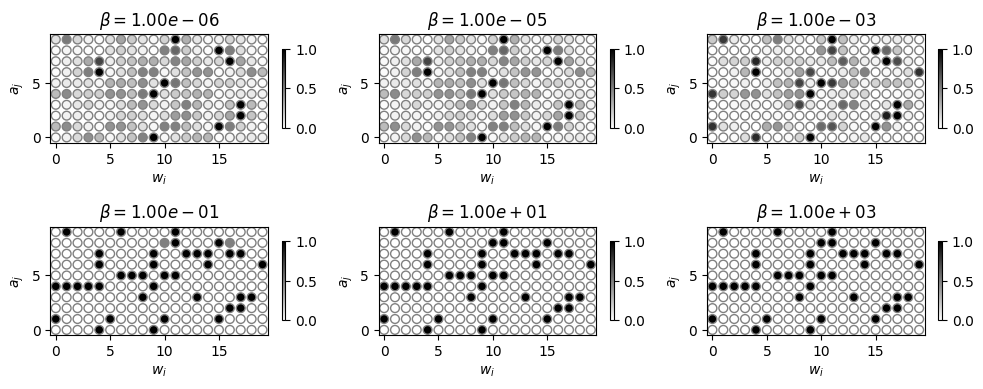

In [30]:
import matplotlib.pyplot as plt
import numpy as np

def plot_matrices_with_discs(matrices, betas):
    """
    Creates a grid of plots for each 2D matrix corresponding to its beta parameter,
    using circular discs to represent the matrix entries in a grayscale gradient.
    
    Args:
    - matrices: List of 2D numpy arrays, each representing a matrix.
    - betas: List of beta parameters corresponding to each matrix.
    """
    n = len(matrices)  # Number of matrices
    cols = 3  # Number of columns in the plot grid
    rows = (n + cols - 1) // cols  # Compute rows to fit all matrices

    fig, axes = plt.subplots(rows, cols, figsize=(10, 2 * rows))
    axes = axes.flatten()  # Flatten the axes for easy iteration

    for i, (matrix, beta) in enumerate(zip(matrices, betas)):
        ax = axes[i]
        rows, cols = matrix.shape
        x, y = np.meshgrid(np.arange(cols), np.arange(rows))
        
        # Flattening coordinates and values for plotting
        x = x.flatten()
        y = y.flatten()
        values = matrix.flatten()
        
        # Plot circular discs using scatter
        scatter = ax.scatter(
            x, y, 
            s=40,  # Size of the circles
            c=values,  # Grayscale color mapped to matrix values
            cmap='gray_r', 
            vmin=0, vmax=1,
            edgecolors='grey'
        )
        ax.set_title(rf"$\beta = {beta:.2e}$", fontsize=12)
        ax.set_xlim(-0.5, cols - 0.5)
        ax.set_ylim(-0.5, rows - 0.5)
        ax.set_aspect('equal')  # Keep circles circular
        ax.set_ylabel(r'$a_j$')
        ax.set_xlabel(r'$w_i$')
        # ax.set_xticks([])
        # ax.set_yticks([])
        # ax.axis('off')  # Turn off axis ticks and labels
        fig.colorbar(scatter, ax=ax, orientation='vertical', shrink=0.5)  # Add a colorbar

    # Remove unused subplots if matrices < rows * cols
    for i in range(len(matrices), len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

def pick_equally_spaced_elements(lst, num_elements=6):
    """
    Pick `num_elements` elements from `lst`, almost equally spaced, including the first and last.
    
    Args:
    - lst (list): Input list of elements (length must be >= num_elements).
    - num_elements (int): Number of elements to pick (default is 6).
    
    Returns:
    - list: Selected elements from the input list.
    """
    if len(lst) < num_elements:
        raise ValueError("The list must have at least as many elements as `num_elements`.")
    
    indices = np.linspace(0, len(lst) - 1, num=num_elements, dtype=int)
    return [lst[i] for i in indices]

betas = pick_equally_spaced_elements(beta_arr, num_elements=6)
matrices = pick_equally_spaced_elements(reach_mat_beta_data, num_elements=6)

# Call the function to plot
plot_matrices_with_discs(matrices, betas)


In [31]:
import pickle
saveData = {'mars':[mars.n_waypoints, mars.n_agents, mars.tolArray, mars.wp_locations, mars.mask, mars.dist_mat],
            'final_schedule':mars.sched_mat,
            'agent_routes':agent_routes,
            'C_arr':C_arr,
            'rt_arr':rt_arr,
            'beta_arr':beta_arr,
            'gamma_arr':gamma_arr,
            'conflict_C_arr':conflict_C_arr,
            'reach_mat_beta_data':reach_mat_beta_data,
            'filter_wp_beta_data':filter_wp_beta_data,
            'agent_schedules':agent_schedules}

filename='na10_nwp20_grid_uniform.pkl'
with open(filename, 'wb') as file:
    pickle.dump(saveData, file)

# with open('mars_object.pkl', 'wb') as file:
#     pickle.dump(mars, file)


In [295]:
# ag1_data = reach_mat_beta_data[:,0,:]
# plt.plot(np.log(beta_arr)/np.log(10), ag1_data)
# legend_str = [str(i) for i in range(ag1_data.shape[1])]
# plt.legend(legend_str)
# plt.show()

# ag2_data = reach_mat_beta_data[:,1,:]
# plt.plot(np.log(beta_arr)/np.log(10), ag2_data)
# plt.legend(legend_str)
# plt.show()

# ag3_data = reach_mat_beta_data[:,2,:]
# plt.plot(np.log(beta_arr)/np.log(10), ag3_data)
# plt.legend(legend_str)
# plt.show()

# plt.plot(np.log(beta_arr)/np.log(10), rt_arr)
# plt.show()

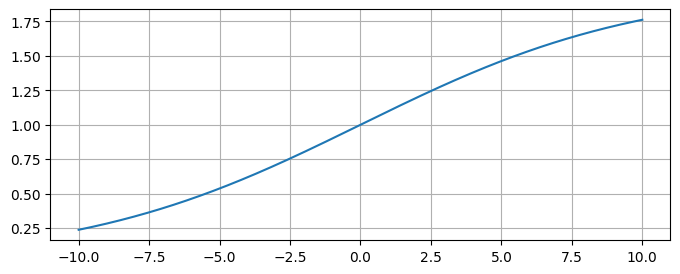

In [73]:
# plot tanh penalty
x = np.linspace(-10,10,1000)
eta = 10
theta = 0.1
# A = 1
# B = 1
# tanh = eta*(1+(1-A*np.exp(-2*x))/(1+B*np.exp(-2*x)))
tanh = eta*theta*(1+np.tanh(theta*(x)))
plt.figure(figsize=(8,3))
plt.plot(x,tanh)
plt.grid()
plt.show()

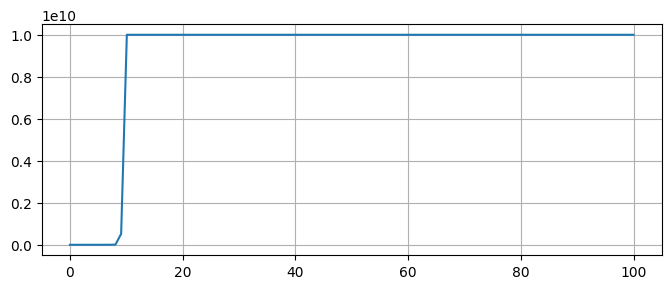

In [29]:
# plot exp penalty
x1 = np.linspace(1e-3, 5, 100)
a1 = 4
a2 = 0.1
expp = np.minimum(a2*np.exp(a1*(x1-3.5)),1e10)
plt.figure(figsize=(8,3))
plt.plot(x1, expp)
plt.grid()
plt.show()


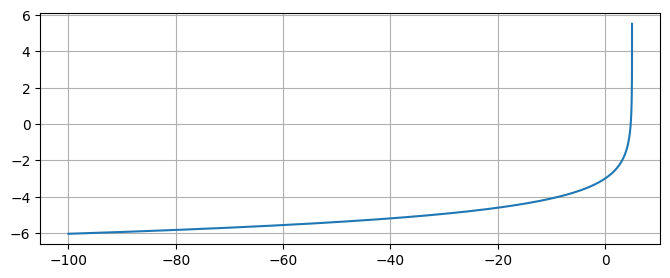

In [105]:
# plot log penalty
x2 = np.linspace(-100, 4.999, 10000)
k1 = 4
k2 = 1
logp = -k2*np.log(k1*(5-x2))
plt.figure(figsize=(8,3))
plt.plot(x2, logp)
plt.grid()
plt.show()


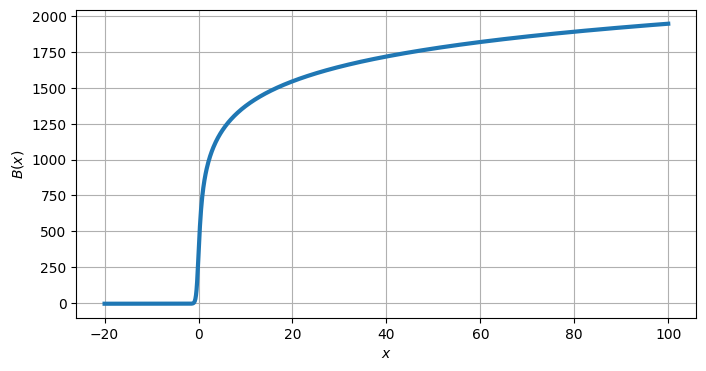

In [47]:
# Alisina's penalty function
scale = 100
offset = 0
z = np.linspace(-20, 100, 1000)

def my_exp(x):
    exp_inf = 700
    return np.exp(np.minimum(x,exp_inf))

gamma1 = 5
coeff1 = 50
zbar1 = (z-offset)
# zbar1 = (offset**2 - np.abs(z)**2)
fz1 = coeff1*gamma1*np.log((
    np.log(my_exp(1/gamma1)+my_exp(gamma1*zbar1))
    )/(
        np.log(my_exp(1/gamma1)+my_exp(-gamma1))
    ))

gamma2 = gamma1
coeff2 = coeff1
zbar2 = (z-offset)
fz2 = coeff2*gamma2*np.log((
    np.log(my_exp(1/gamma2)+my_exp(0.1*gamma2*zbar2))
    )/(
        np.log(my_exp(1/gamma2)+my_exp(-gamma2))
    ))

plt.figure(figsize=(8,4))
plt.plot(z, fz1, label=rf'$\gamma={gamma1}$', linewidth=3)
# plt.plot(z, fz2, label=rf'$\gamma={gamma2}$')
plt.xlabel(rf'$x$')
plt.ylabel(rf'$B(x)$')
plt.grid()
# plt.legend()
plt.show()

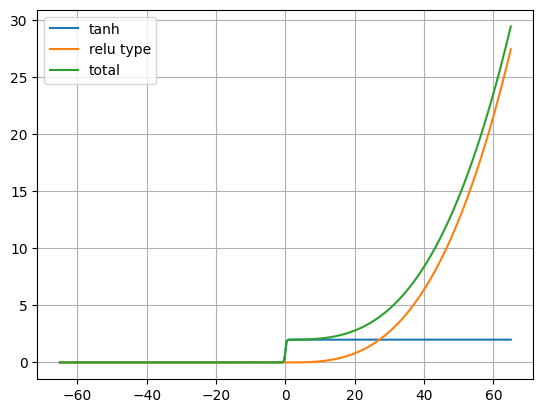

In [199]:
# tanh + quadratic penalty
scale = 100
t1 = np.linspace(-0.65*scale, 0.65*scale, 100*scale)
t01 = 0

fz1 = 1*(1+np.tanh(3*(t1-t01)))
p = 3
fz2 = 0.0001*np.maximum(0,t1**p-t01**p)
fz = fz1 + fz2
plt.plot(t1, fz1, label='tanh')
plt.plot(t1, fz2, label='relu type')
plt.plot(t1, fz, label='total')
plt.grid()
plt.legend()
plt.show()

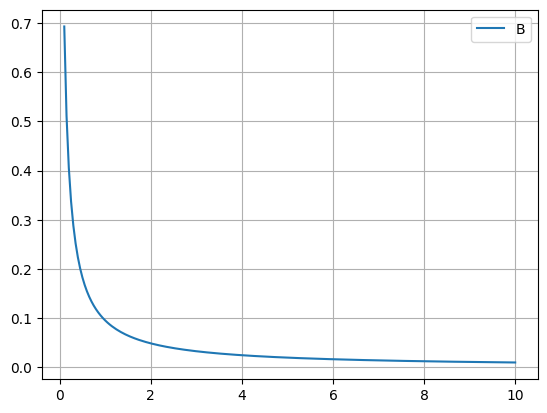

In [3]:
# log penalty
s = np.linspace(1e-1,10,200)
a = 10
B = -np.log(a*s/(a*s+1))
g = 0.1
Bdot = -1/((1+s)*s)
Bdot_lim = g/B
plt.plot(s,B, label='B')
# plt.plot(s,Bdot, label='Bdot')
# plt.plot(s,Bdot_lim, label='Bdot upper lim')
plt.grid()
plt.legend()
plt.show()